In [1]:
import pandas as pd

In [2]:
from sktime.datasets import load_unit_test
df_train, df_train_y= load_unit_test(return_X_y=True, split="train")
df_test, df_test_y =  load_unit_test(return_X_y=True, split="test")

In [3]:
df_train['class']=df_train_y
df_test['class']=df_test_y

In [4]:
from pypelines import ts_regression_pipeline as pipe

In [5]:
tsc = pipe.TSRegressionPipeline(data=df_train,
                                    target_column='class',
                                    models=['CNN'],
                                    test_data=df_test)


In [6]:
tsc.code_to_clipboard()

Fitting 3 folds for each of 2 candidates, totalling 6 fits
1/1 [==============================] - 0s 74ms/step
[CV 1/3] END ........................n_epochs=100;, score=nan total time=   1.0s
1/1 [==============================] - 0s 47ms/step
[CV 2/3] END ........................n_epochs=100;, score=nan total time=   0.7s
1/1 [==============================] - 0s 46ms/step
[CV 3/3] END ........................n_epochs=100;, score=nan total time=   0.7s
1/1 [==============================] - 0s 49ms/step
[CV 1/3] END .......................n_epochs=1100;, score=nan total time=   3.0s
1/1 [==============================] - 0s 52ms/step
[CV 2/3] END .......................n_epochs=1100;, score=nan total time=   2.9s
1/1 [==============================] - 0s 48ms/step
[CV 3/3] END .......................n_epochs=1100;, score=nan total time=   3.0s
2/2 [==============================] - 0s 2ms/step


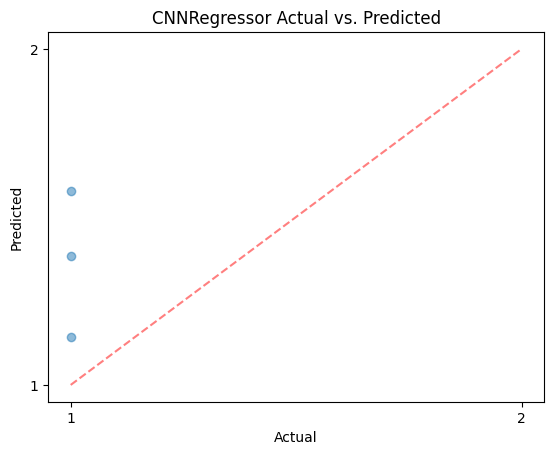

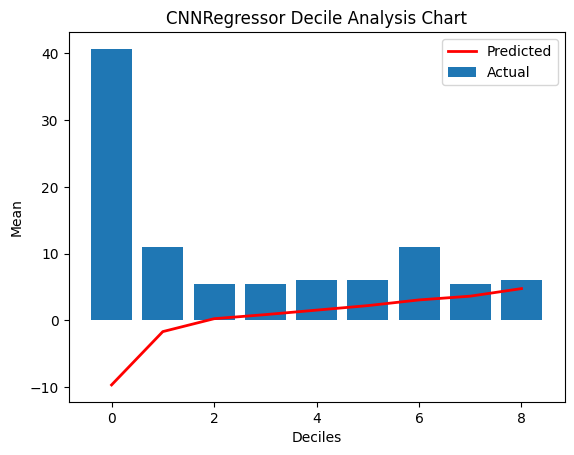

          model    metric       value
0  CNNRegressor  r2_score -193.636441
The best model is CNNRegressor with -193.63644059578442 as r2_score
2/2 [==============================] - 0s 2ms/step
Predictions from best model are stored in test_predictions


In [7]:

from sktime import *
from sklearn.metrics import accuracy_score


import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')


# target dataframe: df_train
target = "class"
features = list(df_train.columns.drop("class"))

# train test split
X_train = df_train[features]
y_train = df_train[target]

X_test = df_test[features]
y_test = df_test[target]

model_comparison_list = []

##### End of Data Processing Pipeline #####


##### Model Pipeline for CNN #####

from sktime.regression.deep_learning.cnn import CNNRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error,make_scorer,r2_score,explained_variance_score
import matplotlib.pyplot as plt
CNNRegressor_param_grid = {
"n_epochs": np.arange(100, 2000, 1000),
}

CNNRegressor_model = CNNRegressor()

# Create the grid search
CNNRegressor_grid_search = GridSearchCV(estimator=CNNRegressor_model, param_grid=CNNRegressor_param_grid, cv=3, scoring=make_scorer(accuracy_score), verbose=3)
CNNRegressor_grid_search.fit(X_train, y_train)

# Get the best hyperparameters
CNNRegressor_best_estimator = CNNRegressor_grid_search.best_estimator_

# Store results as a dataframe  
CNNRegressor_search_results = pd.DataFrame(CNNRegressor_grid_search.cv_results_)


# Generate Predictions
CNNRegressor_predictions = CNNRegressor_best_estimator.predict(X_test)
CNNRegressor_predictions_df = pd.DataFrame(CNNRegressor_best_estimator.predict(X_test))

# Generate Model Metrics
CNNRegressor_r2_score = r2_score(y_test, CNNRegressor_predictions_df.iloc[:,0])
CNNRegressor_mean_squared_error = mean_squared_error(y_test, CNNRegressor_predictions_df.iloc[:,0])
CNNRegressor_explained_variance_score = explained_variance_score(y_test, CNNRegressor_predictions_df.iloc[:,0])
CNNRegressor_performance_metrics = [['CNNRegressor','r2_score', CNNRegressor_r2_score], 
                                  ['CNNRegressor','mean_squared_error',CNNRegressor_mean_squared_error],
                                  ['CNNRegressor','explained_variance_score', CNNRegressor_explained_variance_score]]
CNNRegressor_performance_metrics = pd.DataFrame(CNNRegressor_performance_metrics, columns=['model','metric', 'value'])

# Generate Actual vs Predicted Plot
CNNRegressor_actual_predicted_plot, CNNRegressor_actual_predicted_plot_ax = plt.subplots()
CNNRegressor_actual_predicted_plot = CNNRegressor_actual_predicted_plot_ax.scatter(x=y_test, y=CNNRegressor_predictions_df.iloc[:,0], alpha=0.5)
# Add diagonal line
CNNRegressor_actual_predicted_plot_ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', alpha=0.5)
# Set axis labels and title
CNNRegressor_actual_predicted_plot_ax.set_xlabel('Actual')
CNNRegressor_actual_predicted_plot_ax.set_ylabel('Predicted')
CNNRegressor_actual_predicted_plot_ax.set_title(f'CNNRegressor Actual vs. Predicted')
plt.show(block=False)

# Generate Decile Lift Chart
# Calculate the deciles based on the residuals
CNNRegressor_deciles = np.percentile(CNNRegressor_predictions, np.arange(0, 100, 10))
# Calculate the mean actual and predicted values for each decile
CNNRegressor_mean_actual = []
CNNRegressor_mean_predicted = []
for i in range(len(CNNRegressor_deciles) - 1):
    mask = (CNNRegressor_predictions >= CNNRegressor_deciles[i]) & (CNNRegressor_predictions < CNNRegressor_deciles[i + 1])
    CNNRegressor_mean_actual.append(np.mean(y_test[mask]))
    CNNRegressor_mean_predicted.append(np.mean(CNNRegressor_predictions[mask]))

# Create a bar chart of the mean actual and predicted values for each decile
CNNRegressor_lift_plot, CNNRegressor_lift_plot_ax = plt.subplots()
CNNRegressor_lift_plot_ax.bar(np.arange(len(CNNRegressor_mean_actual)), CNNRegressor_mean_actual, label='Actual')
CNNRegressor_lift_plot_ax.plot(np.arange(len(CNNRegressor_mean_predicted)), CNNRegressor_mean_predicted, color='red', linewidth=2, label='Predicted')
CNNRegressor_lift_plot_ax.set_xlabel('Deciles')
CNNRegressor_lift_plot_ax.set_ylabel('Mean')
CNNRegressor_lift_plot_ax.set_title(f'CNNRegressor Decile Analysis Chart')
CNNRegressor_lift_plot_ax.legend()
plt.show(block=False)


model_comparison_list.append(CNNRegressor_performance_metrics)##### End of Model Pipeline for CNN #####
##### Model Comparison #####
table = pd.concat(model_comparison_list)
table = table.sort_values(by=['value'], ascending=False)
table = table[table['metric'] == 'r2_score']
print(table)
print(f"The best model is {table['model'].iloc[0]} with {table['value'].iloc[0]} as {table['metric'].iloc[0]}")

# Predict test data using the best model
test_predictions = eval(table['model'].iloc[0]+"_best_estimator").predict(X_test)
print('Predictions from best model are stored in test_predictions')
